# Effective time in 2015 J-League: Club Impact in J1

The objective of this analysis is to determine the impact of clubs on the amount of effective playing time relative to the average match.  The difference this season is that we are using Bayesian inference to estimate these impacts.

This notebook makes use of the following packages:

* `numpy`, the main package for scientific computing in Python
* `pandas`, a data manipulation and analysis package
* `pymc`, a Bayesian stochastic modeling package

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os

import pymc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

## Preprocessing the effective time data

The effective time data is stored in a CSV file that contains the home and away teams and the playing time in seconds.  Use the `read_csv()` function in `pandas` to import the CSV file into a `DataFrame`.

In [3]:
DATA_DIR = "."
data_file = os.path.join(DATA_DIR, "JLeague1_2015_Time.csv")
df = pd.read_csv(data_file)

Next, we create a `DataFrame` consisting of the J1 teams.  The `home_team` or `away_team` columns will contain the names of all of the teams in the tournament, so it doesn't matter which column we select. Then we add a column that contains the team's index.  While we are at it, we create a `num_teams` variable to store the number of teams.

In [4]:
teams = df.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index
num_teams = len(teams)

We create `i_home` and `i_away` indices to the original `DataFrame` by merging the two DataFrames (a left join, effectively) and renaming the `i` column.

In [5]:
df = pd.merge(df, teams, left_on='home_team', right_on='team', how='left')
df = df.rename(columns={'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away_team', right_on='team', how='left')
df = df.rename(columns={'i': 'i_away'}).drop('team', 1)

The final step of the preprocessing is to create lists of playing time and the home and away team indices.  These indices are of type `numpy.ndarray`, which is just what we need for `pymc` (runs faster).

In [6]:
apt = df.apt.values
home_team = df.i_home.values
away_team = df.i_away.values
apt_mean = apt.mean()

## Building the Bayesian regression model

The Bayesian regression model is similar to the classic (frequentist) model:

$y = \beta X + \epsilon$

but the difference is that $y$ is drawn from a Normal (Gaussian) process:

$y \in N\left(\beta X, \epsilon\right)$

The coefficients $\beta$ consist of the intercept $\beta_0$, which is the nominal amount of effective playing time, and the team offsets $\beta_{t_i}$.

To get started, we make initial assumptions of the coefficients, or _assign priors_ in Bayesian parlance.  We assume that the true value of $\beta_0$ is close to the average effective time in J1 ($\bar{T}_{ij}$) and comes from a Gaussian distribution.  The team offsets are also Gaussian but centered about zero -- some teams might have more of an effect than others.  The errors are small and can be modeled as Gaussian, but a Uniform distribution makes little difference.

$\beta_0 \in N(\bar{T}_{ij}, 0.0001)$

$\beta_{t_i} \in N(0, 0.0001)$

$\epsilon \in Uniform(0, 500)$

In [7]:
nominal = pymc.Normal('nominal', apt_mean, 0.001)
error = pymc.Uniform('error', 0, 500)

In [8]:
team_offset = np.empty(num_teams, dtype=object)
for i in range(num_teams):
    team_offset[i] = pymc.Normal("team_{}".format(i), 0, 0.0001)

We constrain the team offsets to sum to zero, which reduces the autocorrelation of the posterior samples.  

In [9]:
# create sum-to-zero constraint
@pymc.deterministic
def offsets(team_offset=team_offset):
    offsets = team_offset.copy()
    offsets = offsets - np.mean(offsets)
    return offsets

Now we define the playing time model.  Assuming that $i$ and $j$ represent the home and away team indices, respectively, we define effective time $T_{ij}$ as the following:

$T_{ij} = \beta_0 + \beta_i x_i + \beta_j x_j + \epsilon$

In [10]:
# playing time expression
@pymc.deterministic
def playing_time(home_team=home_team, away_team=away_team, nominal=nominal, offsets=offsets):
    return nominal + offsets[home_team] + offsets[away_team]

In [11]:
# define regression as normal process
Tij = pymc.Normal('apt', playing_time, error, value=apt, observed=True)

Finally we train the playing time model using the Markov Chain Monte Carlo (MCMC) algorithm, and then sample posterior distributions of the parameters: $\beta_0$, $\beta_{t_i}$, and $\epsilon$.

In [12]:
mcmc = pymc.MCMC([Tij, playing_time, offsets, pymc.Container(team_offset), error, nominal])
map_ = pymc.MAP(mcmc)
map_.fit()
mcmc.sample(120000, 30000)

 [-----------------100%-----------------] 120000 of 120000 complete in 1023.6 sec

## Diagnostics

We plot the posterior distributions of the parameters in order to verify that they have converged.

Start with a plot of the trace, autocorrelation, and posterior distribution of $\beta_0$.  The average effective time in 2015 J1 matches is 54 minutes 30 seconds, or 3270 seconds.  The peak of the posterior is almost exactly that, and the spread is very narrow, which indicates a high level of confidence that the nominal effective match time is around 3270 seconds.

Plotting nominal


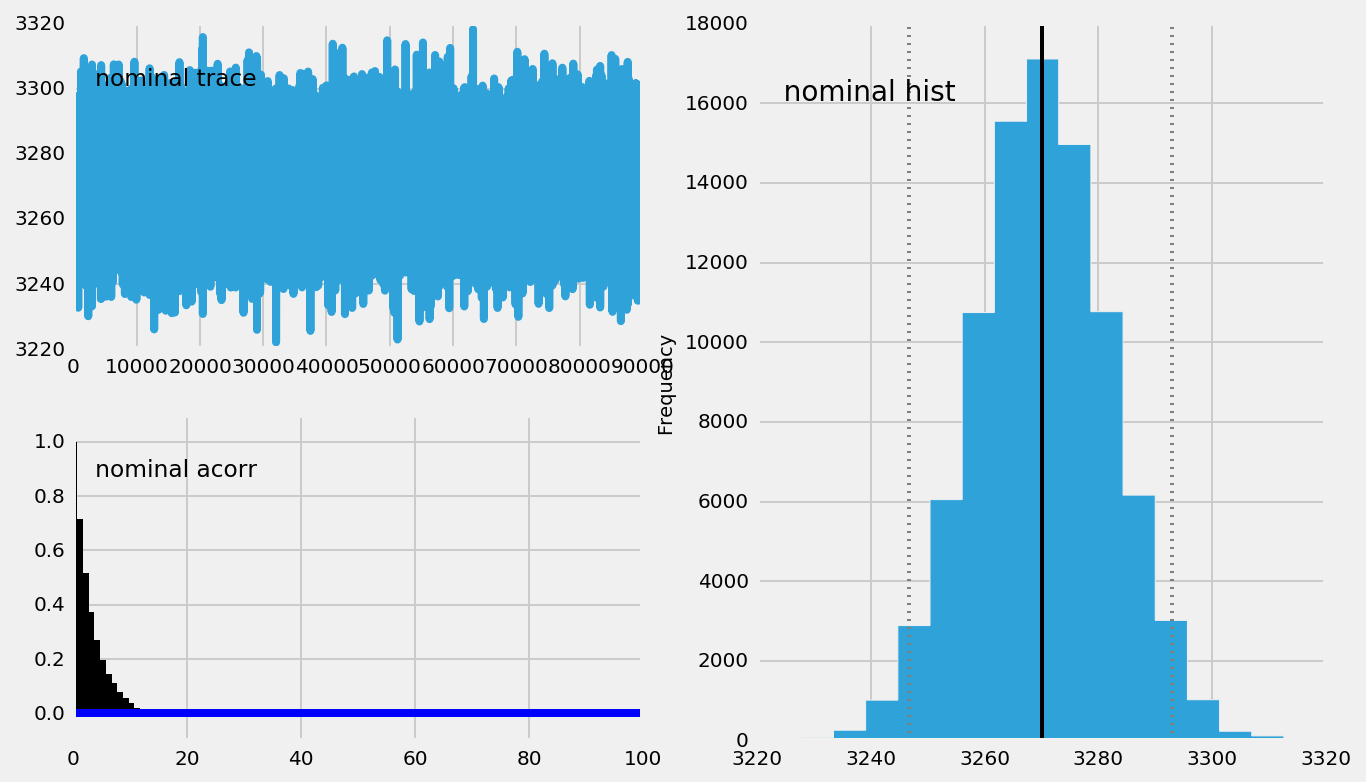

In [13]:
pymc.Matplot.plot(nominal)

The error is small (on order of $10^{-5}$) and appears to be Gaussian.  The autocorrelation is right at zero.  All good.

Plotting error


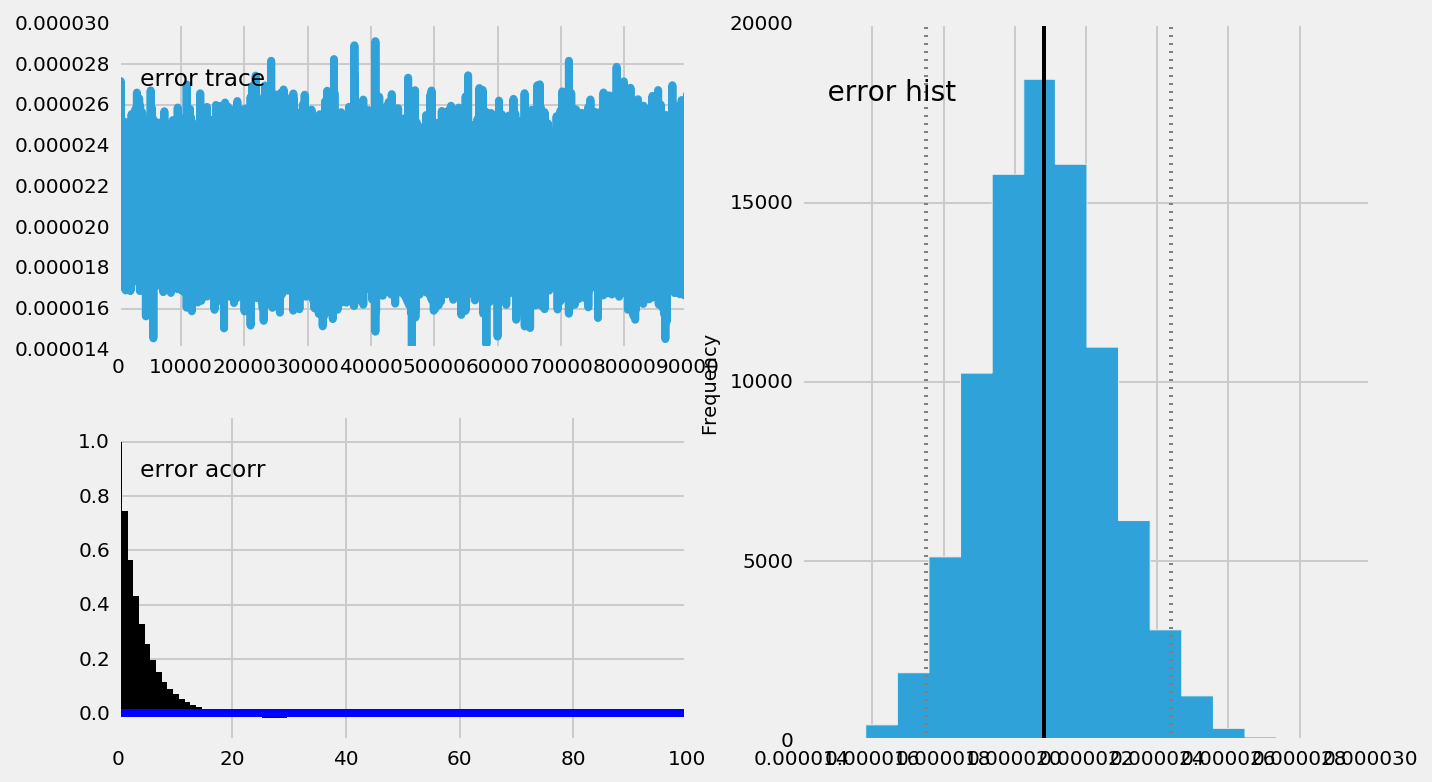

In [14]:
pymc.Matplot.plot(error)

Now we check the output of $team_2$, which corresponds to Urawa Reds.

Plotting team_2


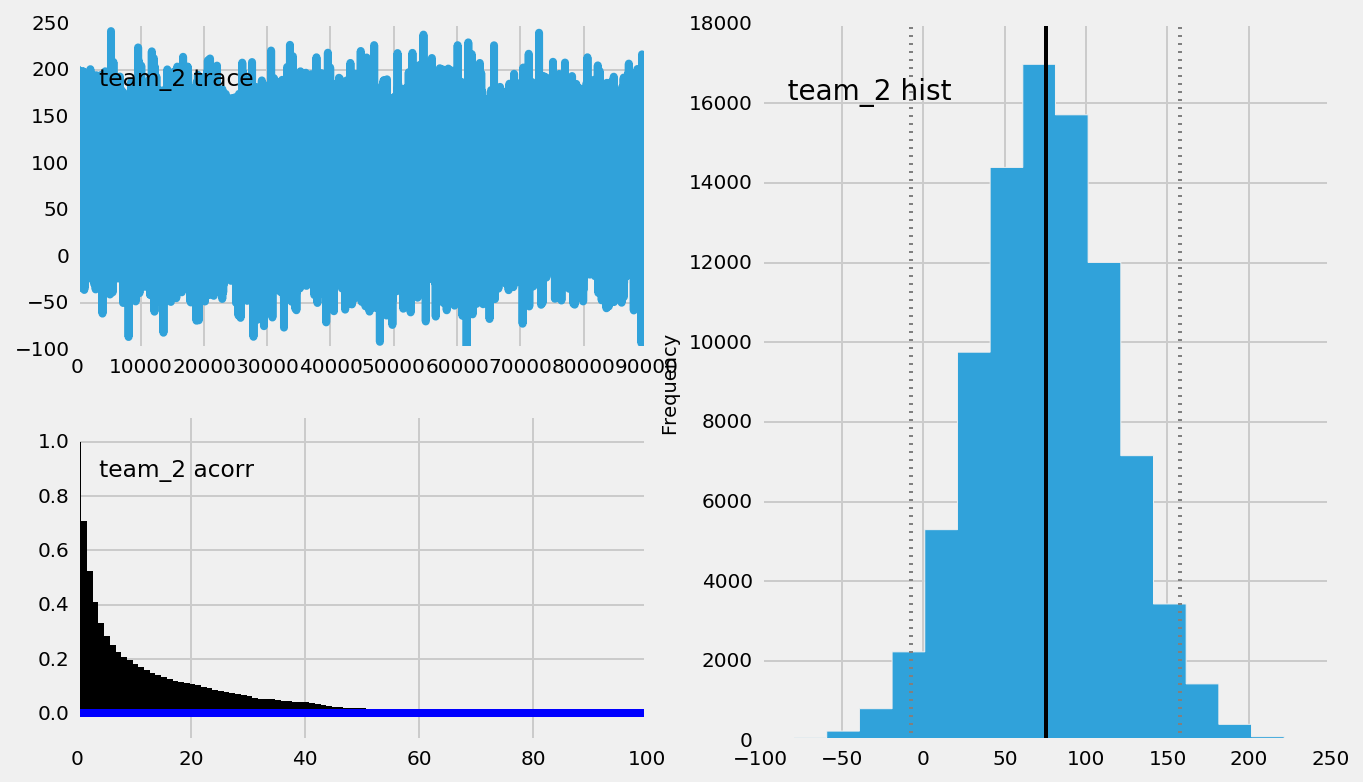

In [15]:
pymc.Matplot.plot(team_offset[2])

## Visualizing club impacts

Create a new `DataFrame` to collect the Highest Posterior Density intervals for the $\beta_{t_i}$ parameters.

In [16]:
hpds = [dict(hpd_low=low, hpd_high=high) for offset in team_offset 
        for (low, high) in [offset.stats()['95% HPD interval'].tolist()]]
medians = [dict(hpd_median=offset.stats()['quantiles'][50]) for offset in team_offset]

df_hpd = pd.DataFrame(hpds, index=teams.team.values)
df_median = pd.DataFrame(medians, index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['y'] = 2*df_hpd.index + 1

/home/howard/.virtualenvs/bayesian/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


The frame will look something like the one below.  It's worth noticing that the distances between the median and the upper and lower bounds of the 95% HPD are very similar among all of the club offsets.  We could have modeled the offsets using a hyperprior, but that seemed like more work.  I'll leave it as an exercise for the interested reader.

In [18]:
df_hpd

,index,hpd_high,hpd_low,hpd_median,relative_lower,relative_upper,y
0,Montedio Yamagata,-164.812096,-328.828525,-246.676680,82.151845,81.864584,1
1,Matsumoto Yamaga FC,-156.508642,-322.044797,-238.770973,83.273824,82.262331,3
2,Sagan Tosu,-71.419784,-236.684623,-151.406633,85.277990,79.986849,5
3,Albirex Niigata,-63.488471,-230.200360,-146.804780,83.395580,83.316309,7
4,FC Tokyo,-28.928228,-194.377096,-109.289426,85.087670,80.361198,9
5,Vegalta Sendai,-16.700712,-182.860482,-100.165791,82.694691,83.465079,11
6,Shimizu S-Pulse,-9.881852,-176.012437,-93.466752,82.545685,83.584900,13
7,Shonan Bellmare,9.700733,-155.654627,-72.565945,83.088682,82.266678,15
8,Nagoya Grampus,32.229161,-133.152229,-50.800118,82.352111,83.029279,17
9,Kashima Antlers,34.122531,-132.285222,-49.447092,82.838130,83.569623,19


Finally we plot the median values of the club impacts on effective playing time with the bounds established by the 95% HPD interval.  As was the case in the 2014 season, the presence of Sanfrecce Hiroshima in a J1 match adds between four and seven minutes to the effective playing time, while the presence of Montedio Yamagata subtracted between 2.5 and 5.5 minutes from the effective playing time.  It is interesting to see the limited turnover compared to last season of teams in the upper half of the club impact chart, with the exception of Urawa Reds and Yokohama F-Marinos.  

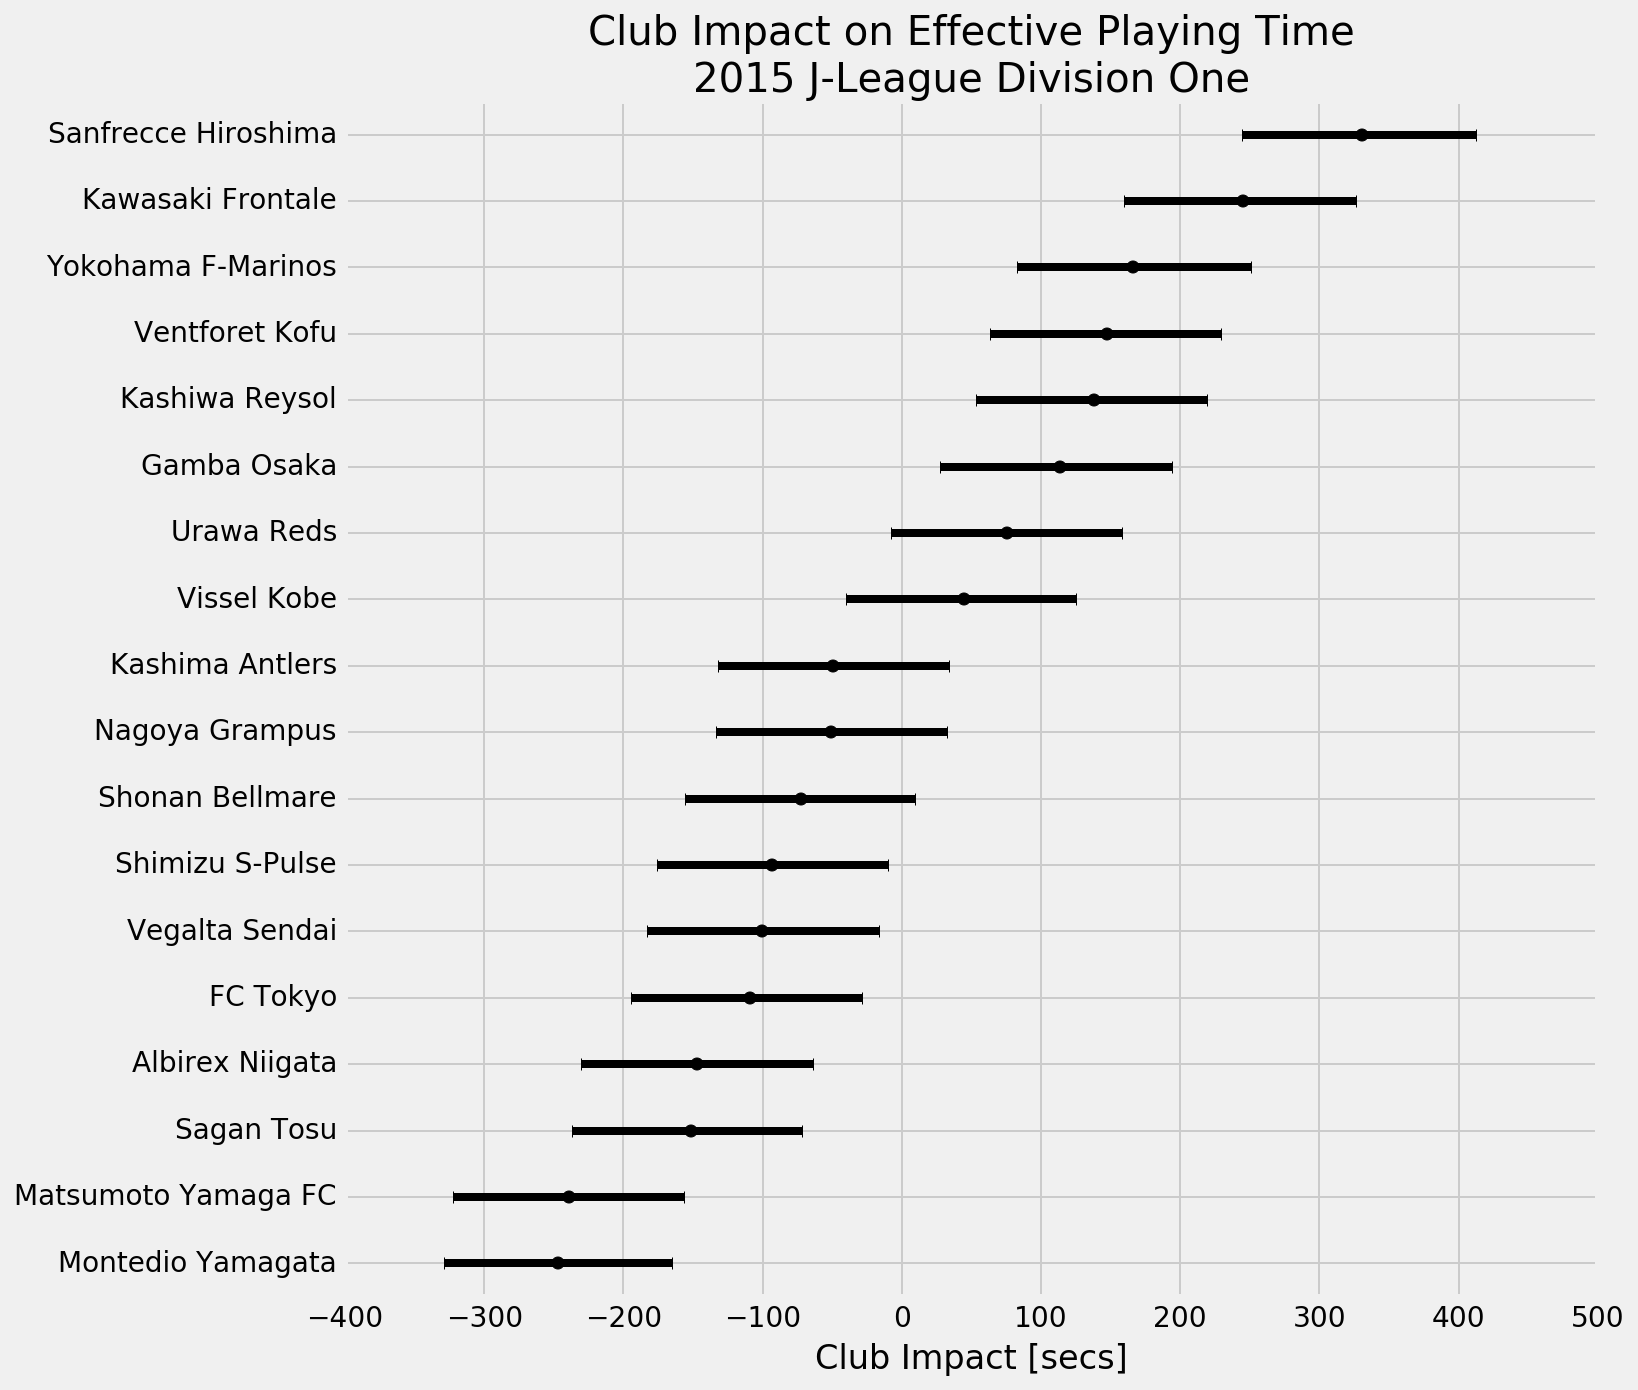

In [36]:
fig, axs = plt.subplots(figsize=(10, 10))
axs.errorbar(df_hpd.hpd_median, df_hpd.y, xerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o', color='k')
axs.set_title('Club Impact on Effective Playing Time\n2015 J-League Division One')
axs.set_xlabel('Club Impact [secs]')

ytic_loc = tuple([0] + df_hpd.y.values.tolist() + [df_hpd.y.max()+1])
ytic_txt = tuple([''] + df_hpd['index'].values.tolist() + [''])

_ = axs.set_yticks(ytic_loc)
_ = axs.set_yticklabels(ytic_txt)